<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/baseline_with_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 이미지 노이즈

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


* 모델 1_baseline1

In [ ]:
# 모델 구조 정의 
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(64,64,3), padding='same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding = 'same', activation= 'relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# 전결합층
model1.add(Flatten())    # 벡터형태로 reshape
model1.add(Dense(512))   # 출력
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(33))
model1.add(Activation('softmax'))

# 모델 구축하기
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model1.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/base_aug_1/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
#earlystop=EarlyStopping(patience=7)

my_callbacks = [checkpoint,annealer]

In [ ]:
baseline1= model1.fit_generator(train_generator,
                               epochs=50,
                               validation_data=validation_generator,
                               callbacks=my_callbacks)

Epoch 1/50
481/481 [==============================] - 4647s 10s/step - loss: 3.4098 - accuracy: 0.1046 - val_loss: 3.2838 - val_accuracy: 0.1341

Epoch 00001: val_accuracy improved from -inf to 0.13406, saving model to /content/gdrive/My Drive/model_save/base_aug_1/01-3.2838.hdf5
Epoch 2/50
481/481 [==============================] - 113s 234ms/step - loss: 3.2616 - accuracy: 0.1243 - val_loss: 3.1372 - val_accuracy: 0.1717

Epoch 00002: val_accuracy improved from 0.13406 to 0.17174, saving model to /content/gdrive/My Drive/model_save/base_aug_1/02-3.1372.hdf5
Epoch 3/50
481/481 [==============================] - 110s 228ms/step - loss: 2.8926 - accuracy: 0.2013 - val_loss: 2.5921 - val_accuracy: 0.2904

Epoch 00003: val_accuracy improved from 0.17174 to 0.29040, saving model to /content/gdrive/My Drive/model_save/base_aug_1/03-2.5921.hdf5
Epoch 4/50
481/481 [==============================] - 111s 231ms/step - loss: 2.5553 - accuracy: 0.2828 - val_loss: 2.3173 - val_accuracy: 0.3944

Ep

In [ ]:
model1.save('/content/gdrive/My Drive/model_save/base_aug_1/baseline1_aug.h5')

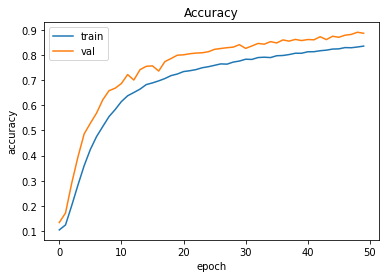

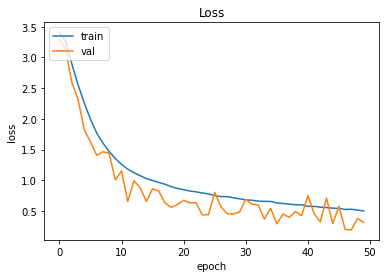

In [ ]:
# accuracy plot 
plt.plot(baseline1.history['accuracy'])
plt.plot(baseline1.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(baseline1.history['loss'])
plt.plot(baseline1.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

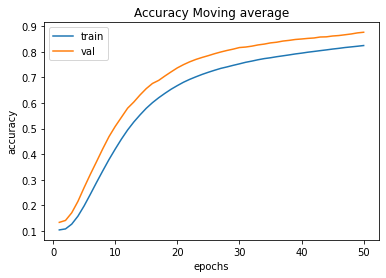

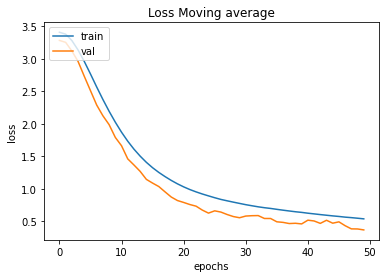

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(baseline1.history['accuracy'])
smooth_mae_history_val = smooth_curve(baseline1.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(baseline1.history['loss']))
plt.plot(smooth_curve(baseline1.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



*   모델 2_baseline4



In [ ]:
# 모델 구조 정의 
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(64,64,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(64, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(128, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3, 3), padding = 'same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# 전결합층
model2.add(Flatten())    # 벡터형태로 reshape
model2.add(Dense(512))   # 출력
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(33))
model2.add(Activation('softmax'))

# 모델 구축하기
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model2.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/base_aug_2/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
#earlystop=EarlyStopping(patience=7)

my_callbacks = [checkpoint,annealer]

In [ ]:
baseline2= model2.fit_generator(train_generator,
                                epochs=50,
                                validation_data=validation_generator,
                                callbacks=my_callbacks)

Epoch 1/50
481/481 [==============================] - 114s 236ms/step - loss: 3.4801 - accuracy: 0.0683 - val_loss: 3.4722 - val_accuracy: 0.1341

Epoch 00001: val_accuracy improved from -inf to 0.13406, saving model to /content/gdrive/My Drive/model_save/base_aug_2/01-3.4722.hdf5
Epoch 2/50
481/481 [==============================] - 111s 231ms/step - loss: 3.4348 - accuracy: 0.1042 - val_loss: 3.4338 - val_accuracy: 0.1341

Epoch 00002: val_accuracy did not improve from 0.13406
Epoch 3/50
481/481 [==============================] - 111s 231ms/step - loss: 3.4189 - accuracy: 0.1045 - val_loss: 3.4402 - val_accuracy: 0.1341

Epoch 00003: val_accuracy did not improve from 0.13406
Epoch 4/50
481/481 [==============================] - 110s 228ms/step - loss: 3.3839 - accuracy: 0.1045 - val_loss: 3.3281 - val_accuracy: 0.1341

Epoch 00004: val_accuracy did not improve from 0.13406
Epoch 5/50
481/481 [==============================] - 110s 228ms/step - loss: 3.2948 - accuracy: 0.1085 - val_lo

In [ ]:
model2.save('/content/gdrive/My Drive/model_save/base_aug_2/baseline2_aug.h5')

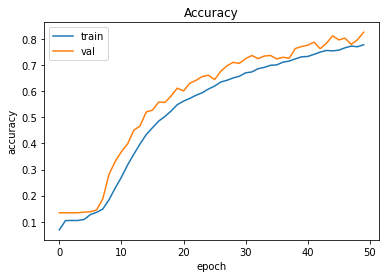

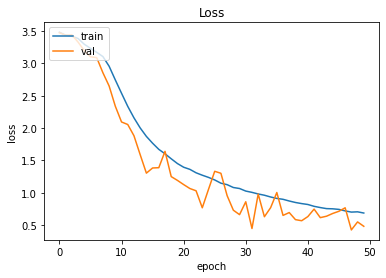

In [ ]:
# accuracy plot 
plt.plot(baseline2.history['accuracy'])
plt.plot(baseline2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(baseline2.history['loss'])
plt.plot(baseline2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

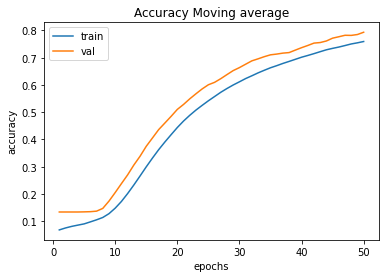

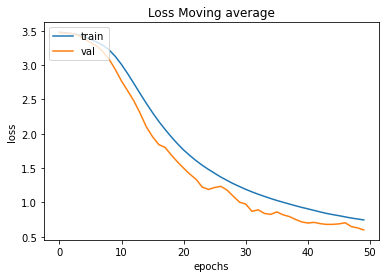

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(baseline2.history['accuracy'])
smooth_mae_history_val = smooth_curve(baseline2.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(baseline2.history['loss']))
plt.plot(smooth_curve(baseline2.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()